# 8. 이미지를 위한 인공 신경망

### 합성곱 convolution

- 입력 데이터에서 유용한 특성만 드러나게 처리하는 것

### 합성곱의 동작 원리

- 입력 데이터 전체에 가중치를 적용하는 게 아니라 일부에 가중치를 곱함
- CNN Convolutional Neural Network에서는 뉴런을 filter/kernel라고 부름
- 필터 filter: 뉴련 개수를 표현할 때
- 커널 kernel: 입력에 곱하는 가중치를 의미할 때
- 합성곱은 2차원 데이터에도 적용할 수 있다. 

![image](https://user-images.githubusercontent.com/81140673/224218029-29cf267c-da2c-4ea7-acc0-b7ad2ede7dce.png)

- 입력 데이터의 왼쪽 위에서 오른쪽 맨 아래까지 이동하면서 출력을 만들어낸다
- 이때 Convolutional 계산을 통해 어든 출력을 Feature map 특성 맵이라고 한다. 

## 8-2. 합성곱 신경망을 사용한 이미지 분류

- 텐서플로 케라스 API로 패션 MNIST 데이터를 CNN으로 분류하기

데이터 불러오기

In [6]:
# 패션 MNIST 불러오기
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
# 255에서 0~1로 정규화하기 -> 깊이를 표시해줘야한다(예를 들면 RGB 이미지는 깊이가 3)
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
# 훈련 셋과 검증 셋으로 나누기
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42
)

### 합성곱 신경망 만들기

![image](https://user-images.githubusercontent.com/81140673/224319621-2659e9e9-55bd-415b-8936-ceb54b880ab6.png)

- 케라스 Sequential 클래스 객체를 만들고 여기에 층을 추가한다
- step 1) 합성곱 층을 추가 (커널로 필터링하고 피처 맵을 도출함)

In [7]:
model = keras.Sequential()
# 합성곱 층
model.add(
    keras.layers.Conv2D(32, # 필터 32개
                        kernel_size=3, # 커널은 3*3
                        activation="relu", # relu 활성화 함수를 사용
                        padding="same", # 세임 패딩 사용
                        input_shape=(28, 28, 1) # input은 28*28인 흑백 이미지
                        )
)

- step 2) 풀링 층 추가하기(이미지 크기를 줄여줌)
- 맥스 풀링: keras.layers.MaxPooling2D
- 평균 풀링: keras.layers.AveragePooling2D

In [8]:
# 풀링 층 2X2
model.add(keras.layers.MaxPooling2D(2))

- step 3) 두번째 합성곱-풀링층 추가하기
- 이때 필터 개수를 64개로 늘린다

In [9]:
# 두번째 합성곱-풀링 층
model.add(keras.layers.Conv2D(64, # 필터 개수 64개
                              kernel_size=3, 
                              activation="relu",
                              padding="same"))
model.add(keras.layers.MaxPooling2D(2))

- step 3) 특성 맵을 일렬로 펼치기

In [10]:
# 일렬로 펼치기
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dropout(0.4)) # 은닉층의 과대적합을 막음
model.add(keras.layers.Dense(10, activation="softmax")) # 다중 분류 문제이므로 softmax

- 모델 구조 출력하기

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

모델 컴파일과 훈련

In [17]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics="accuracy"
)
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "best-cnn-model.h5",
    save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=2, 
    restore_best_weights=True
)
history = model.fit(
    train_scaled, train_target, 
    epochs=20, 
    validation_data=(val_scaled, val_target),
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/20
1500/1500 [==============================] - 62s 40ms/step - loss: 0.5312 - accuracy: 0.8098 - val_loss: 0.3361 - val_accuracy: 0.8770
Epoch 2/20
1500/1500 [==============================] - 62s 42ms/step - loss: 0.3512 - accuracy: 0.8747 - val_loss: 0.2777 - val_accuracy: 0.8950
Epoch 3/20
1500/1500 [==============================] - 50s 33ms/step - loss: 0.3009 - accuracy: 0.8921 - val_loss: 0.2555 - val_accuracy: 0.9066
Epoch 4/20
1500/1500 [==============================] - 54s 36ms/step - loss: 0.2720 - accuracy: 0.9000 - val_loss: 0.2436 - val_accuracy: 0.9107
Epoch 5/20
1500/1500 [==============================] - 53s 36ms/step - loss: 0.2453 - accuracy: 0.9112 - val_loss: 0.2518 - val_accuracy: 0.9073
Epoch 6/20
1500/1500 [==============================] - 51s 34ms/step - loss: 0.2272 - accuracy: 0.9163 - val_loss: 0.2471 - val_accuracy: 0.9103


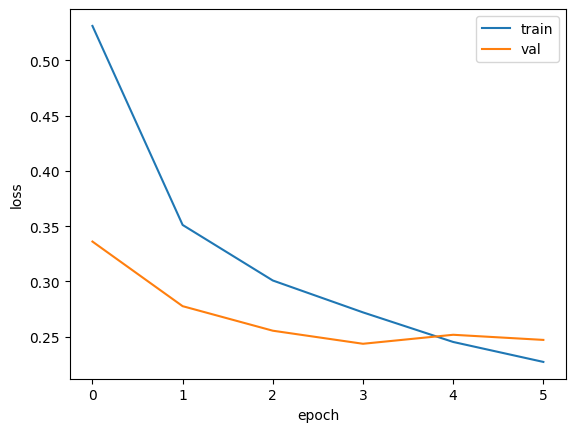

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()

이미지 확인하기 

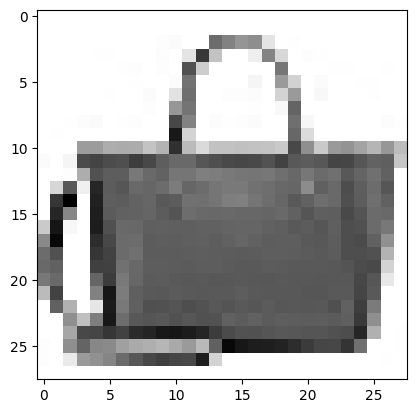

In [19]:
plt.imshow(val_scaled[0].reshape(28, 28), cmap="gray_r")
plt.show()

1/1 [==============================] - 0s 136ms/step
[[3.8481035e-14 1.1127288e-15 3.9119670e-15 6.3330884e-13 4.5871336e-13
  3.6375694e-10 3.1305411e-13 3.2782410e-12 1.0000000e+00 2.4533229e-12]]


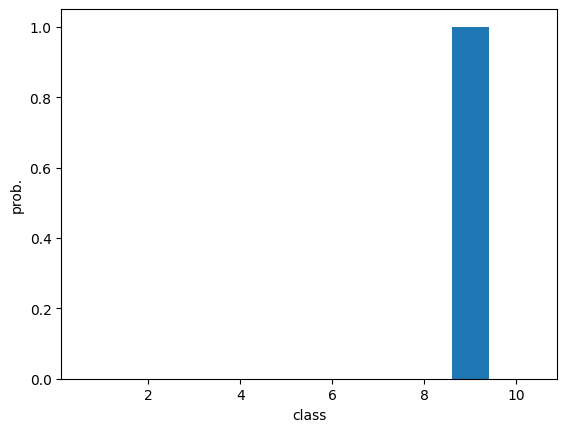

In [20]:
# val_scaled 0:1 데이터에 대한 예측 비율
preds = model.predict(val_scaled[0:1])
print(preds)

# 시각화 결과
plt.bar(range(1, 11), preds[0])
plt.xlabel("class")
plt.ylabel("prob.")
plt.show()

테스트 케이스

In [21]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 3s 9ms/step - loss: 0.2629 - accuracy: 0.9042


[0.2628844380378723, 0.90420001745224]

## 8-3. 합성곱 신경망의 시각화